# 📁 Descargar los Datos

In [666]:
from dotenv import load_dotenv
import os
import boto3

In [667]:
load_dotenv()

AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')
BUCKET_NAME = 'anyoneai-datasets'
PREFIX = 'credit-data-2010/'

s3 = boto3.client('s3', 
                  aws_access_key_id=AWS_ACCESS_KEY_ID,
                  aws_secret_access_key=AWS_SECRET_ACCESS_KEY)

response = s3.list_objects_v2(Bucket=BUCKET_NAME, Prefix=PREFIX)

download_dir = os.path.join('..', 'data', 'raw')
os.makedirs(download_dir, exist_ok=True)

for obj in response.get('Contents', []):
    file_key = obj['Key']
    file_name = file_key.split('/')[-1]
    if file_name:
        dest_path = os.path.join(download_dir, file_name)
        print(f'Downloading {file_name} to {dest_path}...')
        s3.download_file(BUCKET_NAME, file_key, dest_path)

# 👀 Exploración de datos

In [668]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [669]:
# Visual settings
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.2)
plt.rcParams['figure.figsize'] = (10, 6)

In [670]:
# Paths to the downloaded files
var_names_path = os.path.join(download_dir, 'PAKDD2010_VariablesList.XLS')
train_path = os.path.join(download_dir, 'PAKDD2010_Modeling_Data.txt')

# Load variable names
variables_df = pd.read_excel(var_names_path)

col_names = variables_df['Var_Title'].astype(str).tolist()

col_names = (
  pd.Series(col_names)
    .str.strip()
    .str.replace(' ', '_')
    .str.replace('=', '_', regex=False)
    .str.replace('-', '_', regex=False)
    .str.upper()
    .tolist()
)

col_names[43] = 'MATE_EDUCATION_LEVEL'  # Correcting specific column name

df_train = pd.read_csv(
    train_path,
    sep='\t',
    encoding='latin1',
    header=None,
    names=col_names,
    low_memory=False
)

In [671]:
df_train.head()

,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,...,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD_1
0,1,C,5,Web,0,1,F,6,1,0,...,0,0,0,0,1,N,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,0,...,0,0,0,0,1,N,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,0,...,0,0,0,0,1,N,48,235,235,1


In [672]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 54 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID_CLIENT                       50000 non-null  int64  
 1   CLERK_TYPE                      50000 non-null  object 
 2   PAYMENT_DAY                     50000 non-null  int64  
 3   APPLICATION_SUBMISSION_TYPE     50000 non-null  object 
 4   QUANT_ADDITIONAL_CARDS          50000 non-null  int64  
 5   POSTAL_ADDRESS_TYPE             50000 non-null  int64  
 6   SEX                             50000 non-null  object 
 7   MARITAL_STATUS                  50000 non-null  int64  
 8   QUANT_DEPENDANTS                50000 non-null  int64  
 9   EDUCATION_LEVEL                 50000 non-null  int64  
 10  STATE_OF_BIRTH                  50000 non-null  object 
 11  CITY_OF_BIRTH                   50000 non-null  object 
 12  NACIONALITY                     

In [673]:
df_train.describe()

,ID_CLIENT,PAYMENT_DAY,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,NACIONALITY,RESIDENCE_TYPE,MONTHS_IN_RESIDENCE,...,OCCUPATION_TYPE,MATE_PROFESSION_CODE,MATE_EDUCATION_LEVEL,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,AGE,TARGET_LABEL_BAD_1
count,50000.000000,50000.000000,50000.0,50000.000000,50000.00000,50000.000000,50000.0,50000.000000,48651.000000,46223.000000,...,42687.000000,21116.000000,17662.000000,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.00000,50000.000000
mean,25000.500000,12.869920,0.0,1.006540,2.14840,0.650520,0.0,0.961600,1.252225,9.727149,...,2.484316,3.797926,0.296003,0.0,0.0,0.0,0.0,1.275700,43.24852,0.260820
std,14433.901067,6.608385,0.0,0.080606,1.32285,1.193655,0.0,0.202105,0.867833,10.668841,...,1.532261,5.212168,0.955688,0.0,0.0,0.0,0.0,0.988286,14.98905,0.439086
min,1.000000,1.000000,0.0,1.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,6.00000,0.000000
25%,12500.750000,10.000000,0.0,1.000000,1.00000,0.000000,0.0,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,31.00000,0.000000
50%,25000.500000,10.000000,0.0,1.000000,2.00000,0.000000,0.0,1.000000,1.000000,6.000000,...,2.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,41.00000,0.000000
75%,37500.250000,15.000000,0.0,1.000000,2.00000,1.000000,0.0,1.000000,1.000000,15.000000,...,4.000000,11.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,53.00000,1.000000
max,50000.000000,25.000000,0.0,2.000000,7.00000,53.000000,0.0,2.000000,5.000000,228.000000,...,5.000000,17.000000,5.000000,0.0,0.0,0.0,0.0,7.000000,106.00000,1.000000


In [674]:
#Null values check
null_counts = df_train.isnull().sum()
null_percent = (null_counts / len(df_train)) * 100

null_summary = pd.DataFrame({
    'Missing_Count': null_counts,
    'Missing_Percent': null_percent.round(2)
})

null_summary = null_summary[null_summary['Missing_Count'] > 0].sort_values(by='Missing_Percent', ascending=False)

print("📊 Columns with missing values:")
print(null_summary)

📊 Columns with missing values:
                      Missing_Count  Missing_Percent
PROFESSIONAL_BOROUGH          33783            67.57
PROFESSIONAL_CITY             33783            67.57
MATE_EDUCATION_LEVEL          32338            64.68
MATE_PROFESSION_CODE          28884            57.77
PROFESSION_CODE                7756            15.51
OCCUPATION_TYPE                7313            14.63
MONTHS_IN_RESIDENCE            3777             7.55
RESIDENCE_TYPE                 1349             2.70


In [675]:
#Duplicate rows check
duplicate_count = df_train.duplicated().sum()
print("Duplicate rows in the training set:", duplicate_count)

Duplicate rows in the training set: 0


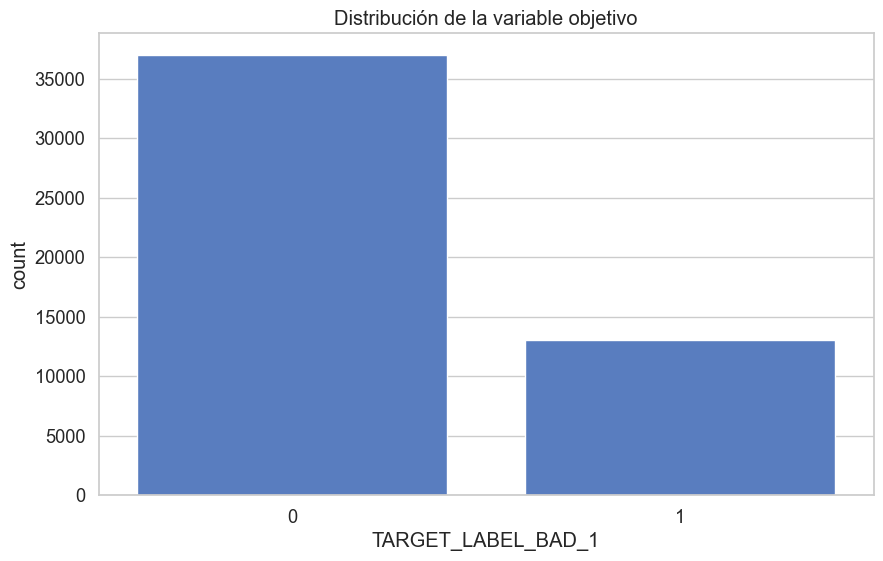

In [676]:
sns.countplot(x="TARGET_LABEL_BAD_1", data=df_train)
plt.title("Distribución de la variable objetivo")
plt.show()

In [677]:
print(df_train["TARGET_LABEL_BAD_1"].value_counts(normalize=True))

TARGET_LABEL_BAD_1
0    0.73918
1    0.26082
Name: proportion, dtype: float64


# 🔢 Correlación con variables númericas

In [678]:
numeric_df = df_train.select_dtypes(include=['int64', 'float64'])
numeric_df.shape

(50000, 34)

In [679]:
correlation_target = numeric_df.corr()['TARGET_LABEL_BAD_1'].sort_values(ascending=False)
print(correlation_target)

TARGET_LABEL_BAD_1                1.000000
PAYMENT_DAY                       0.070633
OCCUPATION_TYPE                   0.040216
PRODUCT                           0.019293
RESIDENCE_TYPE                    0.019168
QUANT_DEPENDANTS                  0.012157
QUANT_SPECIAL_BANKING_ACCOUNTS    0.011997
QUANT_BANKING_ACCOUNTS            0.011997
QUANT_CARS                        0.011706
ID_CLIENT                         0.010509
OTHER_INCOMES                     0.004442
PERSONAL_MONTHLY_INCOME           0.002819
FLAG_DINERS                       0.002240
FLAG_OTHER_CARDS                  0.001410
FLAG_AMERICAN_EXPRESS             0.000337
NACIONALITY                      -0.000952
POSTAL_ADDRESS_TYPE              -0.002423
PERSONAL_ASSETS_VALUE            -0.003886
FLAG_VISA                        -0.005398
MONTHS_IN_THE_JOB                -0.007073
FLAG_EMAIL                       -0.008067
PROFESSION_CODE                  -0.011593
FLAG_MASTERCARD                  -0.017658
MONTHS_IN_R

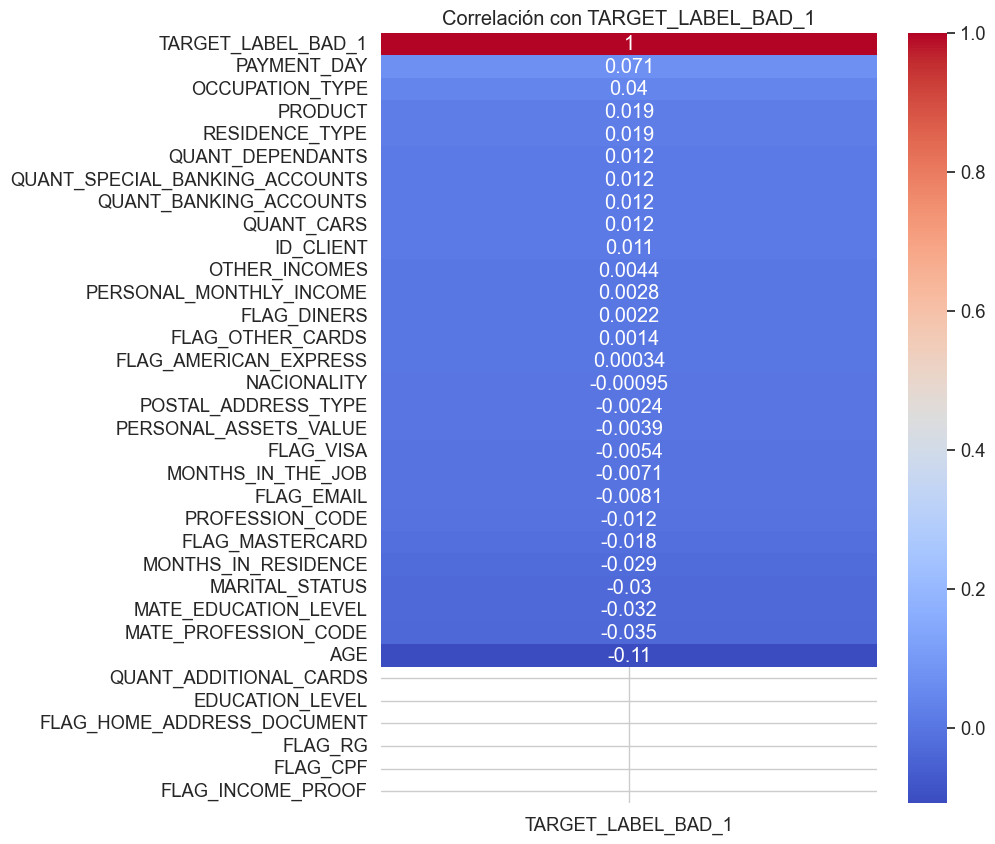

In [680]:
plt.figure(figsize=(8,10))
sns.heatmap(numeric_df.corr()[['TARGET_LABEL_BAD_1']].sort_values(by='TARGET_LABEL_BAD_1', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('Correlación con TARGET_LABEL_BAD_1')
plt.show()

# 🔠 Correlación con variables categoricas

In [681]:
categorical_cols = df_train.select_dtypes(include=['object']).columns
for col in categorical_cols:
    contingency = pd.crosstab(df_train[col], df_train['TARGET_LABEL_BAD_1'])
    chi2, p, dof, ex = chi2_contingency(contingency)
    print(f"{col}: p-value = {p:.4f}")

CLERK_TYPE: p-value = 1.0000
APPLICATION_SUBMISSION_TYPE: p-value = 0.0000
SEX: p-value = 0.0000
STATE_OF_BIRTH: p-value = 0.0000
CITY_OF_BIRTH: p-value = 0.0248
RESIDENCIAL_STATE: p-value = 0.0000
RESIDENCIAL_CITY: p-value = 0.0000
RESIDENCIAL_BOROUGH: p-value = 0.0000
FLAG_RESIDENCIAL_PHONE: p-value = 0.0000
RESIDENCIAL_PHONE_AREA_CODE: p-value = 0.0000
FLAG_MOBILE_PHONE: p-value = 1.0000
COMPANY: p-value = 0.0655
PROFESSIONAL_STATE: p-value = 0.0000
PROFESSIONAL_CITY: p-value = 0.0000
PROFESSIONAL_BOROUGH: p-value = 0.0000
FLAG_PROFESSIONAL_PHONE: p-value = 0.0004
PROFESSIONAL_PHONE_AREA_CODE: p-value = 0.0000
FLAG_ACSP_RECORD: p-value = 1.0000
RESIDENCIAL_ZIP_3: p-value = 0.0000
PROFESSIONAL_ZIP_3: p-value = 0.0000


In [682]:
df_train[categorical_cols].nunique().sort_values(ascending=False)

RESIDENCIAL_BOROUGH             14511
CITY_OF_BIRTH                    9910
PROFESSIONAL_BOROUGH             5057
RESIDENCIAL_CITY                 3529
PROFESSIONAL_CITY                2236
RESIDENCIAL_ZIP_3                 794
PROFESSIONAL_ZIP_3                794
RESIDENCIAL_PHONE_AREA_CODE       102
PROFESSIONAL_PHONE_AREA_CODE       87
STATE_OF_BIRTH                     29
PROFESSIONAL_STATE                 28
RESIDENCIAL_STATE                  27
SEX                                 4
APPLICATION_SUBMISSION_TYPE         3
FLAG_PROFESSIONAL_PHONE             2
FLAG_RESIDENCIAL_PHONE              2
COMPANY                             2
CLERK_TYPE                          1
FLAG_MOBILE_PHONE                   1
FLAG_ACSP_RECORD                    1
dtype: int64

In [683]:
df_train["SEX"].unique()

array(['F', 'M', 'N', ' '], dtype=object)

# 💻 Procesar los datos

In [684]:
# Delete columns with no information (1 category only or 1 numeric value)
drop_cols = ['CLERK_TYPE', 'FLAG_MOBILE_PHONE', 'FLAG_ACSP_RECORD', 'QUANT_ADDITIONAL_CARDS', 'FLAG_HOME_ADDRESS_DOCUMENT', 'FLAG_RG', 'FLAG_CPF', 'FLAG_INCOME_PROOF', 'EDUCATION_LEVEL']
print("Removing columns with no information:", drop_cols)
df_train.drop(columns=drop_cols, inplace=True)

Removing columns with no information: ['CLERK_TYPE', 'FLAG_MOBILE_PHONE', 'FLAG_ACSP_RECORD', 'QUANT_ADDITIONAL_CARDS', 'FLAG_HOME_ADDRESS_DOCUMENT', 'FLAG_RG', 'FLAG_CPF', 'FLAG_INCOME_PROOF', 'EDUCATION_LEVEL']


In [685]:
numeric_real = [
    'AGE',
    'PERSONAL_MONTHLY_INCOME',
    'OTHER_INCOMES',
    'PERSONAL_ASSETS_VALUE',
    'QUANT_CARS',
    'QUANT_DEPENDANTS',
    'QUANT_BANKING_ACCOUNTS',
    'QUANT_SPECIAL_BANKING_ACCOUNTS',
    'MONTHS_IN_THE_JOB',
    'MONTHS_IN_RESIDENCE',
    'PAYMENT_DAY'
]

categorical_encoded = [
    'MARITAL_STATUS',
    'MATE_EDUCATION_LEVEL',
    'RESIDENCE_TYPE',
    'OCCUPATION_TYPE',
    'PRODUCT',
    'POSTAL_ADDRESS_TYPE',
    'PROFESSION_CODE',
    'MATE_PROFESSION_CODE',
    'NACIONALITY'
]

categorical_text = [
    'APPLICATION_SUBMISSION_TYPE',
    'SEX',
    'STATE_OF_BIRTH',
    'CITY_OF_BIRTH',
    'RESIDENCIAL_STATE',
    'RESIDENCIAL_CITY',
    'RESIDENCIAL_BOROUGH',
    'PROFESSIONAL_STATE',
    'PROFESSIONAL_CITY',
    'PROFESSIONAL_BOROUGH',
    'RESIDENCIAL_PHONE_AREA_CODE',
    'PROFESSIONAL_PHONE_AREA_CODE',
    'RESIDENCIAL_ZIP_3',
    'PROFESSIONAL_ZIP_3',
    'COMPANY',
]

flags = [
    'FLAG_RESIDENCIAL_PHONE',
    'FLAG_EMAIL',
    'FLAG_VISA',
    'FLAG_MASTERCARD',
    'FLAG_DINERS',
    'FLAG_AMERICAN_EXPRESS',
    'FLAG_OTHER_CARDS',
    'FLAG_PROFESSIONAL_PHONE',
]

df_train[numeric_real] = df_train[numeric_real].apply(pd.to_numeric, errors='coerce')
df_train[categorical_encoded + categorical_text] = df_train[categorical_encoded + categorical_text].astype('category')
df_train[flags] = (df_train[flags].replace({'Y': 1, 'N': 0}).astype('Int64'))

C:\Users\Usuario\AppData\Local\Temp\ipykernel_100\3181428814.py:58: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train[flags] = (df_train[flags].replace({'Y': 1, 'N': 0}).astype('Int64'))


In [686]:
# Impute missing values
categorical_cols_to_impute = ['PROFESSION_CODE', 'OCCUPATION_TYPE', 'RESIDENCE_TYPE']
for col in categorical_cols_to_impute:
    df_train[col] = df_train[col].fillna(df_train[col].mode()[0])

df_train['MONTHS_IN_RESIDENCE'] = df_train['MONTHS_IN_RESIDENCE'].fillna(df_train['MONTHS_IN_RESIDENCE'].mean())

# Verify imputation
print(df_train[['PROFESSION_CODE', 'OCCUPATION_TYPE', 'RESIDENCE_TYPE', 'MONTHS_IN_RESIDENCE']].isnull().sum())

PROFESSION_CODE        0
OCCUPATION_TYPE        0
RESIDENCE_TYPE         0
MONTHS_IN_RESIDENCE    0
dtype: int64


In [687]:
numeric_df = df_train.select_dtypes(include=['int64', 'float64'])
numeric_df.shape

(50000, 21)

In [688]:
corr = numeric_df.corrwith(df_train['TARGET_LABEL_BAD_1'])
print(corr.sort_values(ascending=False))

TARGET_LABEL_BAD_1                1.000000
PAYMENT_DAY                       0.070633
FLAG_PROFESSIONAL_PHONE           0.015859
QUANT_DEPENDANTS                  0.012157
QUANT_SPECIAL_BANKING_ACCOUNTS    0.011997
QUANT_BANKING_ACCOUNTS            0.011997
QUANT_CARS                        0.011706
ID_CLIENT                         0.010509
OTHER_INCOMES                     0.004442
PERSONAL_MONTHLY_INCOME           0.002819
FLAG_DINERS                       0.002240
FLAG_OTHER_CARDS                  0.001410
FLAG_AMERICAN_EXPRESS             0.000337
PERSONAL_ASSETS_VALUE            -0.003886
FLAG_VISA                        -0.005398
MONTHS_IN_THE_JOB                -0.007073
FLAG_EMAIL                       -0.008067
FLAG_MASTERCARD                  -0.017658
MONTHS_IN_RESIDENCE              -0.028241
FLAG_RESIDENCIAL_PHONE           -0.060750
AGE                              -0.107886
dtype: float64


In [689]:
categorical_cols = df_train.select_dtypes(include=['category']).columns

for col in categorical_cols:
    if df_train[col].nunique() > 1:
        table = pd.crosstab(df_train[col], df_train['TARGET_LABEL_BAD_1'])
        chi2, p, dof, exp = chi2_contingency(table)
        print(f"{col}: p-value = {p:.4f}")

APPLICATION_SUBMISSION_TYPE: p-value = 0.0000
POSTAL_ADDRESS_TYPE: p-value = 0.6322
SEX: p-value = 0.0000
MARITAL_STATUS: p-value = 0.0000
STATE_OF_BIRTH: p-value = 0.0000
CITY_OF_BIRTH: p-value = 0.0248
NACIONALITY: p-value = 0.9661
RESIDENCIAL_STATE: p-value = 0.0000
RESIDENCIAL_CITY: p-value = 0.0000
RESIDENCIAL_BOROUGH: p-value = 0.0000
RESIDENCIAL_PHONE_AREA_CODE: p-value = 0.0000
RESIDENCE_TYPE: p-value = 0.0000
COMPANY: p-value = 0.0655
PROFESSIONAL_STATE: p-value = 0.0000
PROFESSIONAL_CITY: p-value = 0.0000
PROFESSIONAL_BOROUGH: p-value = 0.0000
PROFESSIONAL_PHONE_AREA_CODE: p-value = 0.0000
PROFESSION_CODE: p-value = 0.0000
OCCUPATION_TYPE: p-value = 0.0000
MATE_PROFESSION_CODE: p-value = 0.0001
MATE_EDUCATION_LEVEL: p-value = 0.0000
PRODUCT: p-value = 0.0000
RESIDENCIAL_ZIP_3: p-value = 0.0000
PROFESSIONAL_ZIP_3: p-value = 0.0000


In [690]:
df_train[categorical_encoded + categorical_text].nunique().sort_values(ascending=False)

RESIDENCIAL_BOROUGH             14511
CITY_OF_BIRTH                    9910
PROFESSIONAL_BOROUGH             5057
RESIDENCIAL_CITY                 3529
PROFESSIONAL_CITY                2236
PROFESSIONAL_ZIP_3                794
RESIDENCIAL_ZIP_3                 794
RESIDENCIAL_PHONE_AREA_CODE       102
PROFESSIONAL_PHONE_AREA_CODE       87
STATE_OF_BIRTH                     29
PROFESSIONAL_STATE                 28
RESIDENCIAL_STATE                  27
PROFESSION_CODE                    19
MATE_PROFESSION_CODE               18
MARITAL_STATUS                      8
MATE_EDUCATION_LEVEL                6
RESIDENCE_TYPE                      6
OCCUPATION_TYPE                     6
SEX                                 4
PRODUCT                             3
APPLICATION_SUBMISSION_TYPE         3
NACIONALITY                         3
POSTAL_ADDRESS_TYPE                 2
COMPANY                             2
dtype: int64

In [691]:
# Delete columns with high percentage of missing values
high_missing_cols = null_summary[null_summary['Missing_Percent'] > 50].index.tolist()
print("Removing columns with more than 50% missing values:", high_missing_cols)
df_train.drop(columns=high_missing_cols, inplace=True)

Removing columns with more than 50% missing values: ['PROFESSIONAL_BOROUGH', 'PROFESSIONAL_CITY', 'MATE_EDUCATION_LEVEL', 'MATE_PROFESSION_CODE']


In [692]:
# Delete columns with high cardinality
categorical_cols = df_train.select_dtypes(include=['category']).columns

high_cardinality_cols = df_train[categorical_cols].nunique()
high_cardinality_cols = high_cardinality_cols[high_cardinality_cols > 500].index.tolist()
print("Removing columns with high cardinality:", high_cardinality_cols)
df_train.drop(columns=high_cardinality_cols, inplace=True)


Removing columns with high cardinality: ['CITY_OF_BIRTH', 'RESIDENCIAL_CITY', 'RESIDENCIAL_BOROUGH', 'RESIDENCIAL_ZIP_3', 'PROFESSIONAL_ZIP_3']


In [693]:
# Delete columns with high p-value (low correlation with target)
cols_to_check = df_train.select_dtypes(include=['category']).columns
for col in cols_to_check:
    if df_train[col].nunique() > 1:
        table = pd.crosstab(df_train[col], df_train['TARGET_LABEL_BAD_1'])
        chi2, p, dof, exp = chi2_contingency(table)
        if p > 0.05:
            print(f"Removing column {col} with p-value = {p:.4f}")
            df_train.drop(columns=[col], inplace=True)

Removing column POSTAL_ADDRESS_TYPE with p-value = 0.6322
Removing column NACIONALITY with p-value = 0.9661
Removing column COMPANY with p-value = 0.0655


In [694]:
# Delete columns wit low correlation with target
min_correlation = 0.05
max_correlation = 0.99

always_exclude = ['ID_CLIENT', 'TARGET_LABEL_BAD_1']

corr_abs = corr.abs()

cols_to_keep = corr_abs[
    (corr_abs >= min_correlation) & 
    (corr_abs <= max_correlation) & 
    (~corr_abs.index.isin(always_exclude))
].index.tolist()

cols_to_drop = [col for col in numeric_df.columns if col not in cols_to_keep and col not in always_exclude]

print(f"Columnas a mantener ({len(cols_to_keep)}): {cols_to_keep}")
print(f"\nColumnas a descartar ({len(cols_to_drop)}): {cols_to_drop}")

df_train = df_train.drop(columns=cols_to_drop, errors='ignore')

Columnas a mantener (3): ['PAYMENT_DAY', 'FLAG_RESIDENCIAL_PHONE', 'AGE']

Columnas a descartar (16): ['QUANT_DEPENDANTS', 'MONTHS_IN_RESIDENCE', 'FLAG_EMAIL', 'PERSONAL_MONTHLY_INCOME', 'OTHER_INCOMES', 'FLAG_VISA', 'FLAG_MASTERCARD', 'FLAG_DINERS', 'FLAG_AMERICAN_EXPRESS', 'FLAG_OTHER_CARDS', 'QUANT_BANKING_ACCOUNTS', 'QUANT_SPECIAL_BANKING_ACCOUNTS', 'PERSONAL_ASSETS_VALUE', 'QUANT_CARS', 'FLAG_PROFESSIONAL_PHONE', 'MONTHS_IN_THE_JOB']


In [695]:
df_train['SEX'] = df_train['SEX'].str.strip()
df_train['SEX'] = df_train['SEX'].replace('M', 'MALE')
df_train['SEX'] = df_train['SEX'].replace('F', 'FEMALE')
df_train['SEX'] = df_train['SEX'].replace('N', 'OTHER')
df_train['SEX'] = df_train['SEX'].replace('', 'OTHER')
df_train['SEX'].value_counts()

SEX
FEMALE    30805
MALE      19130
OTHER        65
Name: count, dtype: int64

In [696]:
df_train.shape

(50000, 17)

In [697]:
df_train.columns

Index(['ID_CLIENT', 'PAYMENT_DAY', 'APPLICATION_SUBMISSION_TYPE', 'SEX',
       'MARITAL_STATUS', 'STATE_OF_BIRTH', 'RESIDENCIAL_STATE',
       'FLAG_RESIDENCIAL_PHONE', 'RESIDENCIAL_PHONE_AREA_CODE',
       'RESIDENCE_TYPE', 'PROFESSIONAL_STATE', 'PROFESSIONAL_PHONE_AREA_CODE',
       'PROFESSION_CODE', 'OCCUPATION_TYPE', 'PRODUCT', 'AGE',
       'TARGET_LABEL_BAD_1'],
      dtype='object')